In [1]:
import sys
import os

sys.path.append("..")  # proje kök klasörüne erişim
import pandas as pd
import numpy as np
import json
import time
import joblib
from utils.model_train_functions import ModelTrainFunctions
import catboost as cb
from catboost import CatBoostRegressor, Pool
import optuna
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

seed_value = 277
random.seed(seed_value)
np.random.seed(seed_value)

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())  # Proje kök klasörünü al
unseen_size = 744  # Gelecek 31 gün için saatlik tahmin
train_data_path = BASE_DIR + "\\data\\raw\\"

mtf = ModelTrainFunctions()
historical_data, forecast_data = mtf.get_data(data_path=train_data_path)

In [3]:
train = historical_data.iloc[:-unseen_size, :]
unseen = historical_data.iloc[-unseen_size:, :]
forecast = forecast_data.copy()
cat_cols = train.select_dtypes(include=["category", "object"]).columns.tolist()
train.shape, unseen.shape, forecast.shape

((46032, 357), (744, 357), (48, 357))

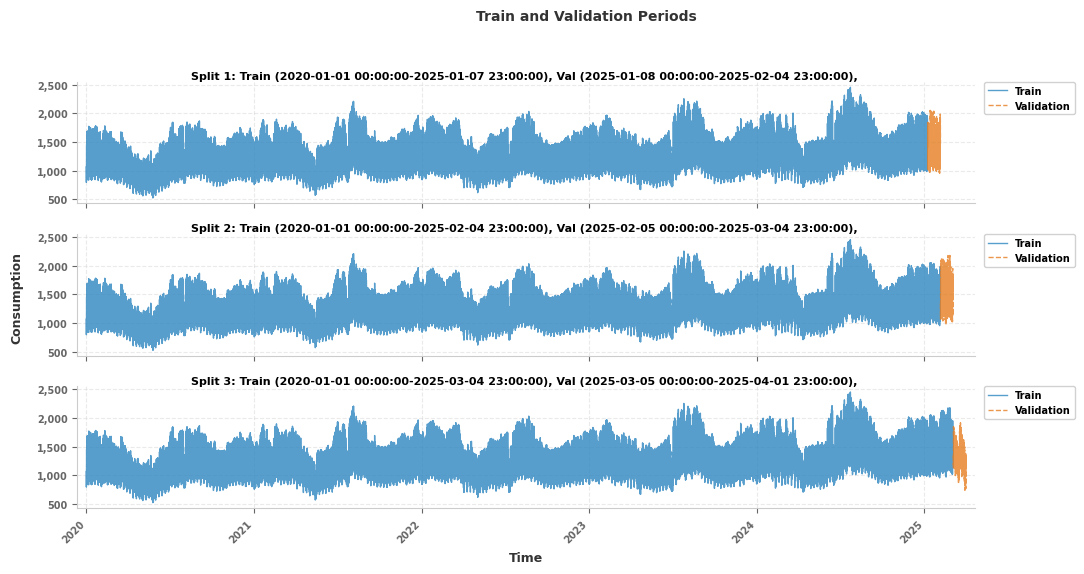

In [4]:
val_size = 672
n_splits = 3
splits_info = mtf.get_tscv_splits((train.index), n_splits=n_splits, test_size=val_size)
mtf.plot_splits(splits_info, train["consumption"])

In [5]:
mtf.print_splits_info(splits_info)

Split 1:
  Train: 2020-01-01 --> 2025-01-07
  Val:  2025-01-08 --> 2025-02-04
----------------------------------------
Split 2:
  Train: 2020-01-01 --> 2025-02-04
  Val:  2025-02-05 --> 2025-03-04
----------------------------------------
Split 3:
  Train: 2020-01-01 --> 2025-03-04
  Val:  2025-03-05 --> 2025-04-01
----------------------------------------


In [6]:
start_1 = time.time()
model_performance = {}
selected_cols = []

es = 50
verbose = 500

data = train.copy()


def objective(trial):
    model_performance[trial.number] = {}
    loss_function = trial.suggest_categorical("loss_function", ["RMSE"])

    param = {
        "iterations": trial.suggest_int("iterations", 1500, 1500),
        "loss_function": loss_function,
        "eval_metric": trial.suggest_categorical("eval_metric", ["RMSE"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "allow_writing_files": False,
    }

    start_time = time.time()

    total_mape_train = 0
    total_mape_val = 0
    total_mape_unseen = 0

    split_count = len(splits_info)

    for split in splits_info:
        split_name = split["name"]
        print(f"\n\nTraining on Trial: {trial.number} , {split_name}\n")
        train = data[split["train_period"][0] : split["train_period"][1]].drop(
            columns=selected_cols
        )
        val = data[split["val_period"][0] : split["val_period"][1]].drop(
            columns=selected_cols
        )
        X_train, y_train = train.drop(columns=["consumption"]), train["consumption"]
        print("Train data shape:", X_train.shape)
        print("Target length:", len(y_train))
        print("Any NaN in target:", y_train.isna().sum())
        print("Unique values in target:", y_train.unique())

        X_val, y_val = val.drop(columns=["consumption"]), val["consumption"]
        print(
            f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}"
        )

        cat_cols = X_train.select_dtypes(
            include=["category", "object"]
        ).columns.tolist()
        train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, label=y_val, cat_features=cat_cols)

        model = CatBoostRegressor(**param)
        model.fit(
            train_pool, eval_set=val_pool, early_stopping_rounds=es, verbose=verbose
        )

        train_result = model.predict(X_train)
        val_result = model.predict(X_val)
        unseen_predict = model.predict(unseen.drop(columns="consumption"))

        train_mape_df, train_mape = mtf.calculate_mape(y_train, train_result)
        val_mape_df, val_mape = mtf.calculate_mape(y_val, val_result)
        unseen_mape_df, unseen_mape = mtf.calculate_mape(
            unseen["consumption"], unseen_predict
        )

        total_mape_train += train_mape
        total_mape_val += val_mape
        total_mape_unseen += unseen_mape

        print(
            f"Score Train - {split_name}: {train_mape},\nScore Val - {split_name}: {val_mape},\nScore Unseen - {split_name}: {unseen_mape}"
        )
        print(
            f"Actual Mean: {np.mean(unseen['consumption']):.3f},\nPredicted Mean: {np.mean(unseen_predict):.3f}"
        )
        print("*" * 50, "\n")

        # Model performansını kaydetme
        model_performance[trial.number][split_name] = {
            "hyperparameters": param,
            "model": model,
            "train_mape": train_mape,
            "val_mape": val_mape,
            "unseen_mape": unseen_mape,
            "evals_result": model.get_evals_result(),
            "importance": model.get_feature_importance(),
            "train_df": train_mape_df,
            "val_df": val_mape_df,
            "unseen_df": unseen_mape_df,
            "train": train,
            "val": val,
            "unseen": unseen,
        }

    val_mape_set = {}
    for col in model_performance[trial.number].keys():
        val_mape = mtf.calculate_mape(
            model_performance[trial.number][col]["val_df"]["Gerçek"].values,
            model_performance[trial.number][col]["val_df"]["Tahmin"].values,
        )[1]
        val_mape_set[col] = val_mape
    val_mape_set = pd.DataFrame(
        data=val_mape_set.items(), columns=["Split", "Val_MAPE"]
    )
    val_mape_std = np.std(val_mape_set["Val_MAPE"])
    val_mape_mean = np.mean(val_mape_set["Val_MAPE"])

    base_average_mape = total_mape_val / split_count
    print(
        f"Trial completed in {(time.time() - start_time) / 60:.2f} minutes with average Validation MAPE: %{val_mape_mean:.3f} and STD: %{val_mape_std:.3f}"
    )

    return val_mape_mean


study = optuna.create_study(
    direction="minimize",
    study_name="CatBoost TSS Optimization",
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=seed_value),
)
study.optimize(
    objective,
    n_trials=1,
    show_progress_bar=True,
    # n_jobs=-1
)

end_1 = time.time()
print(f"Trials completed in {(end_1 - start_1) / 60:.2f} minutes")

[I 2025-06-29 22:24:09,606] A new study created in memory with name: CatBoost TSS Optimization


  0%|          | 0/1 [00:00<?, ?it/s]



Training on Trial: 0 , Split 1

Train data shape: (44016, 356)
Target length: 44016
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1600.353008   1526.020218
 1408.550543  ]
Training data shape: (44016, 356), Validation data shape: (672, 356)
0:	learn: 300.4951882	test: 364.6644267	best: 364.6644267 (0)	total: 231ms	remaining: 5m 45s
500:	learn: 32.5204313	test: 47.5833884	best: 47.5833884 (500)	total: 40.4s	remaining: 1m 20s
1000:	learn: 24.8422102	test: 42.7548181	best: 42.7262704 (999)	total: 1m 20s	remaining: 40.2s
1499:	learn: 20.9041554	test: 40.8447107	best: 40.8385499 (1494)	total: 2m 2s	remaining: 0us

bestTest = 40.83854991
bestIteration = 1494

Shrink model to first 1495 iterations.
Score Train - Split 1: 1.2,
Score Val - Split 1: 2.02,
Score Unseen - Split 1: 2.83
Actual Mean: 1337.883,
Predicted Mean: 1326.401
************************************************** 



Training on Trial: 0 , Split 2

Train data shape: (44688, 356)


In [7]:
study.trials_dataframe().sort_values("value")

,number,value,datetime_start,datetime_complete,duration,params_eval_metric,params_iterations,params_learning_rate,params_loss_function,state
0,0,2.683333,2025-06-29 22:24:09.612927,2025-06-29 22:30:26.264418,0 days 00:06:16.651491,RMSE,1500,0.030514,RMSE,COMPLETE


In [8]:
best_model_performance = model_performance[study.best_trial.number]

In [9]:
for split in best_model_performance.keys():
    print(f"{split}")
    print(f"Train MAPE: {best_model_performance[split]['train_mape']:.2f}")
    print(f"Validation MAPE: {best_model_performance[split]['val_mape']:.2f}")
    print(f"Unseen MAPE: {best_model_performance[split]['unseen_mape']:.2f}")
    print("-" * 50)

Split 1
Train MAPE: 1.20
Validation MAPE: 2.02
Unseen MAPE: 2.83
--------------------------------------------------
Split 2
Train MAPE: 1.20
Validation MAPE: 2.63
Unseen MAPE: 2.96
--------------------------------------------------
Split 3
Train MAPE: 1.22
Validation MAPE: 3.40
Unseen MAPE: 2.94
--------------------------------------------------


In [10]:
train_mape_mean = np.mean(
    [
        best_model_performance[split]["train_mape"]
        for split in best_model_performance.keys()
    ]
)
train_mape_std = np.std(
    [
        best_model_performance[split]["train_mape"]
        for split in best_model_performance.keys()
    ]
)
val_mape_mean = np.mean(
    [
        best_model_performance[split]["val_mape"]
        for split in best_model_performance.keys()
    ]
)
val_mape_std = np.std(
    [
        best_model_performance[split]["val_mape"]
        for split in best_model_performance.keys()
    ]
)
unseen_mape_mean = np.mean(
    [
        best_model_performance[split]["unseen_mape"]
        for split in best_model_performance.keys()
    ]
)
unseen_mape_std = np.std(
    [
        best_model_performance[split]["unseen_mape"]
        for split in best_model_performance.keys()
    ]
)

print(
    "Train MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(
        train_mape_mean, train_mape_std
    )
)
print(
    "Train MAPE Dağılımı",
    [
        float(best_model_performance[split]["train_mape"])
        for split in best_model_performance
    ],
)
print("*" * 50)
print(
    "Validation MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(
        val_mape_mean, val_mape_std
    )
)
print(
    "Validation MAPE Dağılımı",
    [
        float(best_model_performance[split]["val_mape"])
        for split in best_model_performance
    ],
)
print("*" * 50)
print(
    "Unseen MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(
        unseen_mape_mean, unseen_mape_std
    )
)
print(
    "Unseen MAPE Dağılımı",
    [
        float(best_model_performance[split]["unseen_mape"])
        for split in best_model_performance
    ],
)
print("*" * 50)

Train MAPE: Ortalama 1.21, Standart Sapma 0.01
Train MAPE Dağılımı [1.2, 1.2, 1.22]
**************************************************
Validation MAPE: Ortalama 2.68, Standart Sapma 0.56
Validation MAPE Dağılımı [2.02, 2.63, 3.4]
**************************************************
Unseen MAPE: Ortalama 2.91, Standart Sapma 0.06
Unseen MAPE Dağılımı [2.83, 2.96, 2.94]
**************************************************


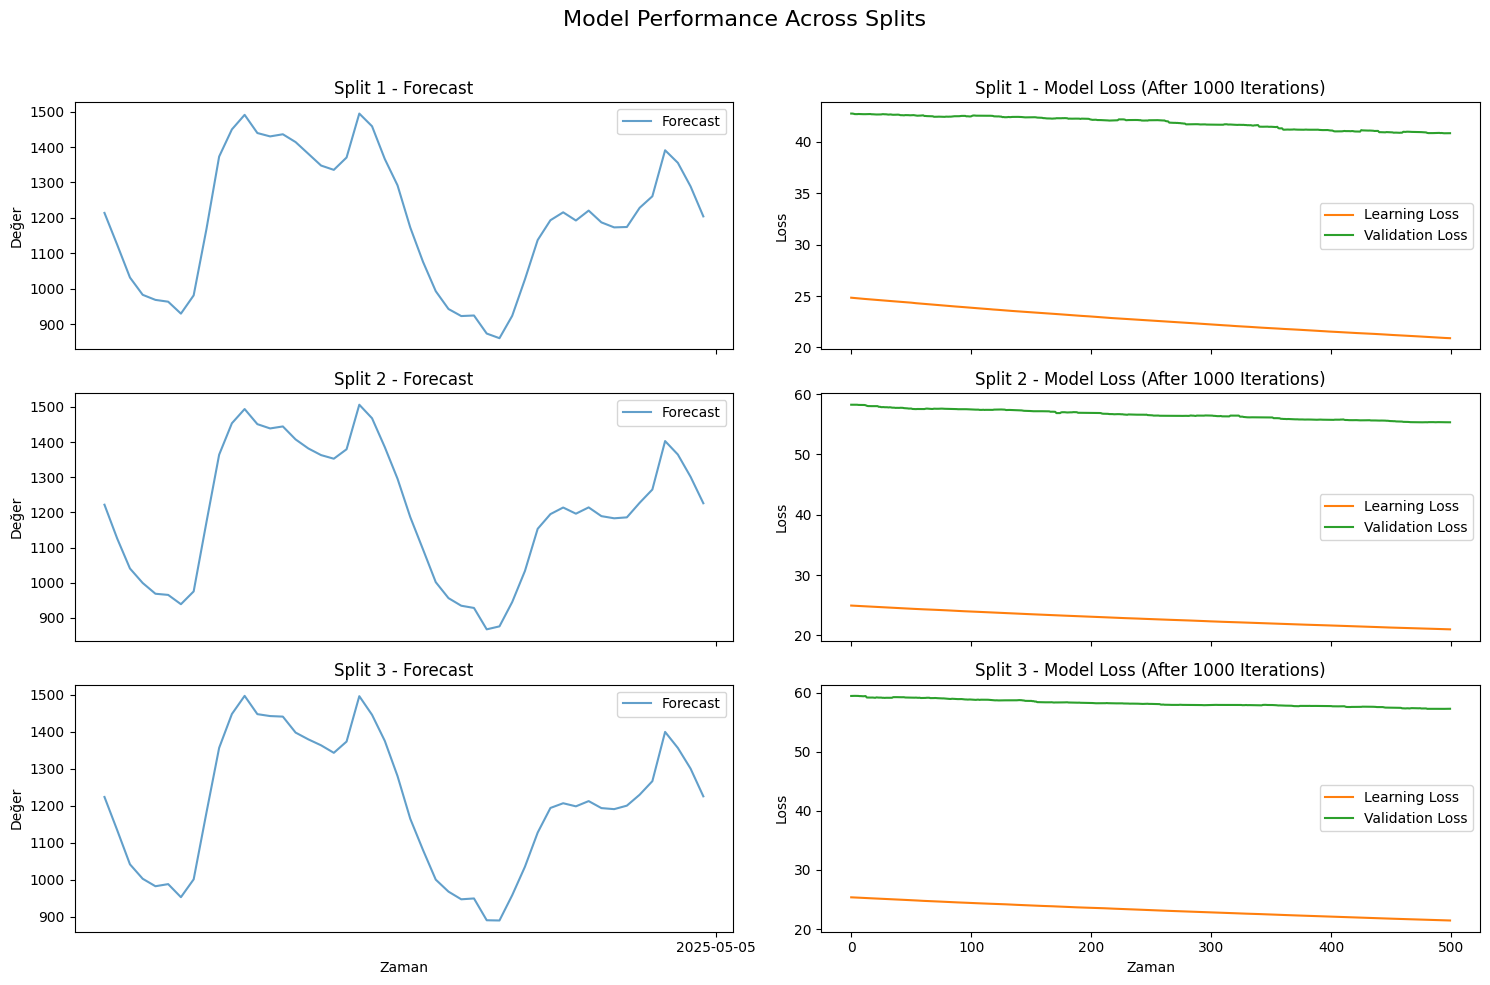

In [11]:
X_forecast = forecast.drop("consumption", axis=1)
model_result = pd.DataFrame(index=X_forecast.index)
X_forecast = X_forecast.drop(columns=selected_cols)
X_forecast = cb.Pool(X_forecast, cat_features=cat_cols)

learn_metric = best_model_performance["Split 1"]["hyperparameters"]["eval_metric"]

after_iter = 1000
fig, axs = plt.subplots(
    len(best_model_performance.keys()), 2, figsize=(15, 10), sharex="col"
)
fig.suptitle("Model Performance Across Splits", fontsize=16)
split_names = [col for col in best_model_performance.keys() if "Split" in col]

for i, split in enumerate(split_names):
    modelx = best_model_performance[split]["model"]
    history = best_model_performance[split]["evals_result"]

    # 1. Forecast Plot
    forecast_predictions = modelx.predict(X_forecast)
    model_result[split] = forecast_predictions

    date_range = pd.to_datetime(forecast.index)

    axs[i, 0].plot(
        date_range, forecast_predictions, label="Forecast", color="tab:blue", alpha=0.7
    )
    axs[i, 0].set_title(f"{split} - Forecast")
    axs[i, 0].set_ylabel("Değer")
    axs[i, 0].legend()
    axs[i, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    axs[i, 0].xaxis.set_major_locator(mdates.DayLocator(interval=5))

    # 2. Model Loss Plot
    axs[i, 1].plot(
        history["learn"][learn_metric][after_iter:],
        label="Learning Loss",
        color="tab:orange",
    )
    axs[i, 1].plot(
        history["validation"][learn_metric][after_iter:],
        label="Validation Loss",
        color="tab:green",
    )
    axs[i, 1].set_title(f"{split} - Model Loss (After {after_iter} Iterations)")
    axs[i, 1].set_ylabel("Loss")
    axs[i, 1].legend()

# Genel ayarlamalar
for ax in axs[-1, :]:  # Son satırın x ekseninde tarih formatı ayarı
    ax.set_xlabel("Zaman")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

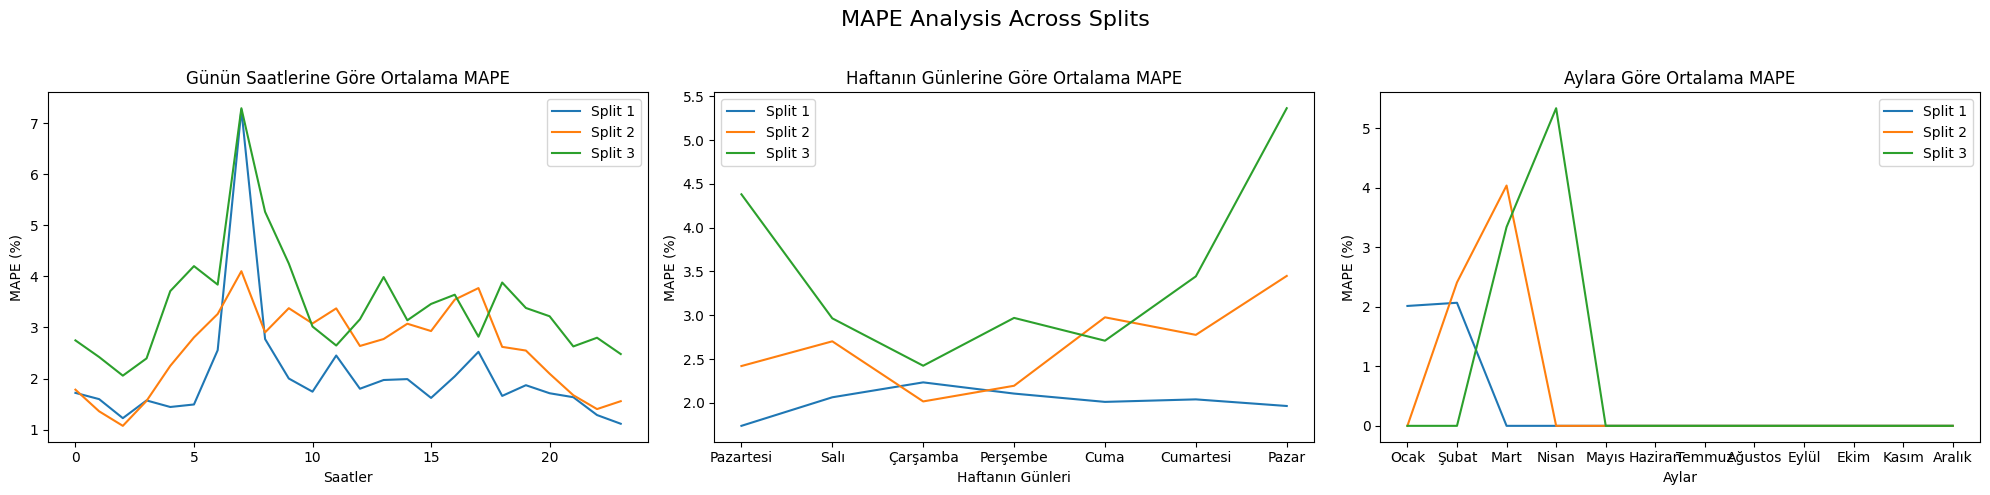

In [12]:
mtf.all_splits_mape_analysis(best_model_performance)

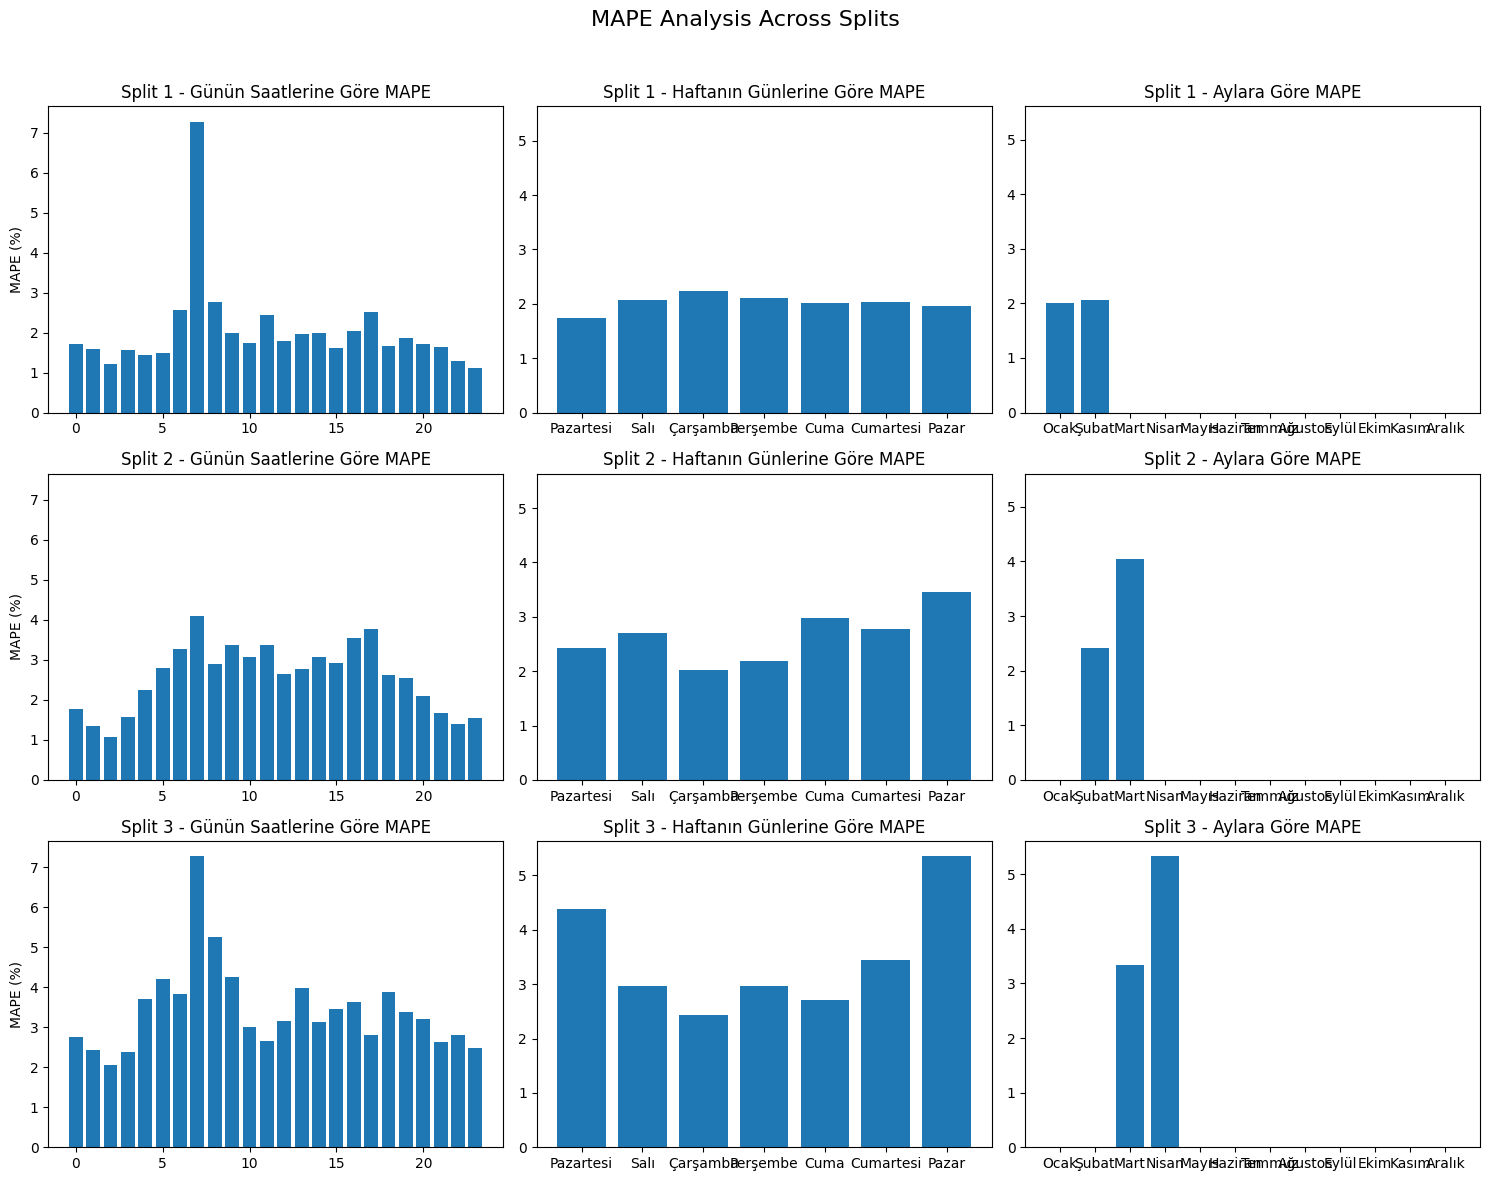

In [13]:
mtf.all_splits_mape_analysis_v2(best_model_performance)

In [14]:
predicts = {}

split_names = [col for col in best_model_performance.keys() if "Split" in col]
for split in split_names:
    split_model = best_model_performance[split]["model"]
    split_predict = split_model.predict(
        best_model_performance[split_names[-1]]["unseen"].drop(columns="consumption")
    )
    predicts[split] = split_predict
predicts = pd.DataFrame(predicts)

predicts.index = best_model_performance[split_names[-1]]["unseen_df"].index
predicts["Gerçek"] = best_model_performance[split_names[-1]]["unseen_df"][
    "Gerçek"
].values

mape_scores = {}
for col in predicts.columns:
    mape_scores[col] = mtf.calculate_mape(predicts["Gerçek"], predicts[col])[1]
all_mape_df = pd.DataFrame(mape_scores.items(), columns=["Model", "Unseen Mape"]).iloc[
    :-1, :
]
all_mape_df["Validation Mape"] = [
    best_model_performance[split]["val_mape"] for split in best_model_performance.keys()
]

all_mape_df

,Model,Unseen Mape,Validation Mape
0,Split 1,2.83,2.02
1,Split 2,2.96,2.63
2,Split 3,2.94,3.40


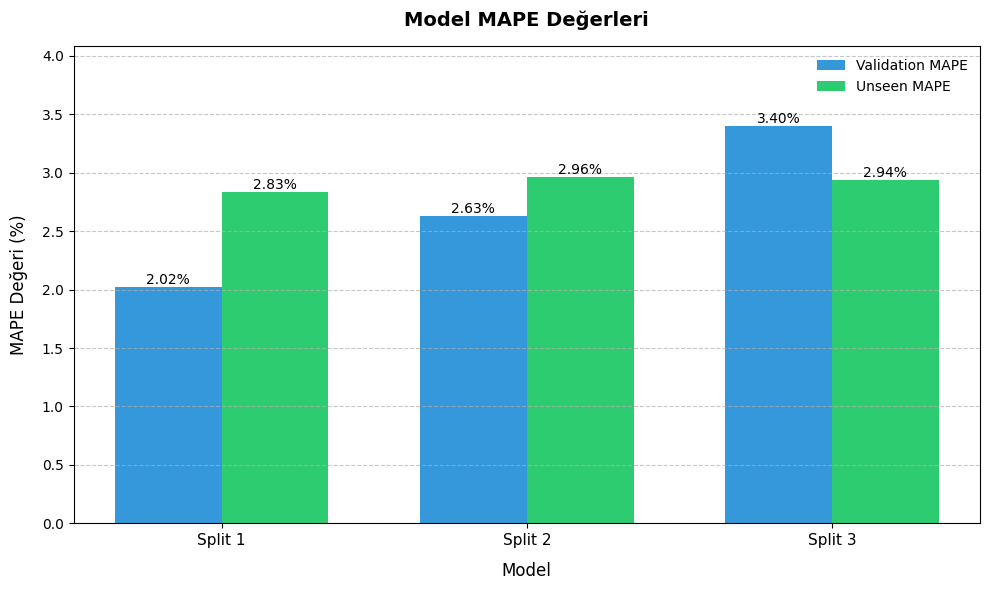

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Çubuk genişliği ve konum ayarları
bar_width = 0.35
index = all_mape_df.index

# Çubuk grafikleri çiz
bars1 = ax.bar(
    index - bar_width / 2,
    all_mape_df["Validation Mape"],
    bar_width,
    color="#3498db",
    label="Validation MAPE",
)
bars2 = ax.bar(
    index + bar_width / 2,
    all_mape_df["Unseen Mape"],
    bar_width,
    color="#2ecc71",
    label="Unseen MAPE",
)

# Başlık ve etiketler
ax.set_title("Model MAPE Değerleri", pad=15, fontsize=14, fontweight="bold")
ax.set_xlabel("Model", fontsize=12, labelpad=10)
ax.set_ylabel("MAPE Değeri (%)", fontsize=12, labelpad=10)

# X ekseni etiketlerini düzenle
ax.set_xticks(index)
ax.set_xticklabels(all_mape_df["Model"], fontsize=11)

# Y eksenini çerçeveye sığdır
ax.set_ylim(
    0, max(all_mape_df["Validation Mape"].max(), all_mape_df["Unseen Mape"].max()) * 1.2
)

# Izgara çizgileri
ax.grid(True, linestyle="--", alpha=0.7, axis="y")

# Çubukların üstüne değer yaz
for bars, label in zip([bars1, bars2], ["Validation Mape", "Unseen Mape"]):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
        )

# Lejant
ax.legend(loc="upper right", fontsize=10, frameon=False)

# Layout ayarları
fig.tight_layout()

# Grafiği göster
plt.show()

In [16]:
for split in best_model_performance.keys():
    r2 = r2_score(
        best_model_performance[split]["unseen_df"]["Gerçek"],
        best_model_performance[split]["unseen_df"]["Tahmin"],
    )

    # Veri ve değişken sayısı
    n = len(best_model_performance[split]["unseen_df"])  # Veri noktalarının sayısı
    p = best_model_performance[split]["unseen_df"].shape[
        1
    ]  # Bağımsız değişkenlerin sayısı

    # Adjusted R² hesaplama
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

    print(f"{split}          R²: {r2:.4f}")
    print(f"{split} Adjusted R²: {adjusted_r2:.4f}")
    print("\n")

Split 1          R²: 0.9631
Split 1 Adjusted R²: 0.9630


Split 2          R²: 0.9592
Split 2 Adjusted R²: 0.9590


Split 3          R²: 0.9620
Split 3 Adjusted R²: 0.9619




In [ ]:
# "T V U --M {:.2f}, {:.2f}, {:.2f} ---- T V U--S {:.2f}, {:.2f}, {:.2f}".format(train_mape_mean,val_mape_mean,unseen_mape_mean,
#                                                                                   train_mape_std,val_mape_std,unseen_mape_std)

In [17]:
model_ımp = best_model_performance["Split 3"]["model"].get_feature_importance(
    prettified=True,
    type="LossFunctionChange",
    data=Pool(
        historical_data.drop(columns="consumption"),
        historical_data["consumption"],
        cat_features=cat_cols,
    ),
)
model_ımp.loc[model_ımp.Importances > 1]["Feature Id"].tolist()

['consumption_lag_168',
 'PK-Ticarethane - AG',
 'PK-Sanayi-OG',
 'consumption_lag_336',
 'date_hour_sin',
 'consumption_lag_48',
 'PK-Ticarethane - OG',
 'date_hour',
 'date_day_of_week',
 'PK-Sanayi-AG',
 'consumption_lag_49',
 'daylight_hours',
 'consumption_window_50_max',
 'consumption_window_49_std',
 'consumption_window_48_max',
 'consumption_window_49_max',
 'azimuth_direction',
 'Holiday_Flag',
 'azimuth',
 'consumption_window_51_max',
 'consumption_lag_504',
 'consumption_lag_672']

In [ ]:
joblib.dump(
    best_model_performance,
    f"C:/Users/pc/Desktop/ULUDAG-ENERJI-DAGITILAN/models/"
    + "T V U --M {:.2f}, {:.2f}, {:.2f} ---- T V U--S {:.2f}, {:.2f}, {:.2f}".format(
        train_mape_mean,
        val_mape_mean,
        unseen_mape_mean,
        train_mape_std,
        val_mape_std,
        unseen_mape_std,
    )
    + ".joblib",
)

In [18]:
exp_model = best_model_performance["Split 3"]["model"]
exp_model.save_model(
    "C:/Users/pc/Desktop/ULUDAG-ENERJI-DAGITILAN/models/exp_model.cbm", format="cbm"
)